# Overview

# Business Understanding

# Data Understanding

## Limitations

# Data Analysis

## Preparation

Before we dive into modeling, we will have to make sure the data is ready for our neural networks to process. The process for preparing image data has a few extra steps, as we need to essentially create a slightly augmented and formatted reproduction of our original images before we feed them into the network. The generation and augmentation process involves editing things like the size of the image (these models generally need uniform sizing). Optionally, we can add further augmentations such as random changes in zoom, skewing the images one way or the other, and even flipping images vertically or horizontally. This can add some more noise to the training data, sometimes improving outcomes. Since this is medical data, however, I want to refrain from making too many changes.

Another challenge facing us is the size of our validation set. While there are over 5000 images in our train set, our validation set is only 16 images. Since we are using backpropagation in our models, having inaccurate or otherwise wonky results on the validation set can hinder the model's self-improvement. We will want to draw a far larger sample for our validation data. My solution is to just split the large training set into 85% train and 15% validation.

Finally, we must also address the fairly-large class imbalance in the training data. While such imbalances are common in real-world data, it would be prefarable to even this dataset out a little bit so our model can't just get away with guessing one class over and over. We can do this in myriad ways, but I have chosen to experiment with downsampling the majority class and applying different class weights during training to artificially increase the importance of the minority class.

Below, I will go through a brief exploratory process before moving on to addressing our preprocessing challenges.

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow
import os, shutil
from shutil import copyfile
import random
import tensorflow as tf
import scikeras
import seaborn as sns
import sympy
from sympy import symbols, Eq, solve
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers, models
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from skimage.segmentation import mark_boundaries
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import scipy
from scipy import ndimage
from keras import models
from keras import layers
from keras import regularizers
from lime import lime_image
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Since we can't just throw this data into pandas like we do for text or tabular data, we'll need to define some system paths so we can more easily navigate to and from image directories during preprocessing, training, and testing. Let's define some pathways below:

In [2]:
train_dir = '/Users/adampell/Documents/Flatiron/phase-4/phase-4-project/data/chest_xray/train'
val_dir = '/Users/adampell/Documents/Flatiron/phase-4/phase-4-project/data/chest_xray/val'
test_dir = '/Users/adampell/Documents/Flatiron/phase-4/phase-4-project/data/chest_xray/test'

In [3]:
train_normal_dir = '/Users/adampell/Documents/Flatiron/phase-4/phase-4-project/data/chest_xray/train/NORMAL'
train_pneumonia_dir = '/Users/adampell/Documents/Flatiron/phase-4/phase-4-project/data/chest_xray/train/PNEUMONIA'

Now that we've defined those pathways, let's create some quick functions to see what these images actually look like. Notice that, when we're loading these images, we actually have to open the file, load the image into a tensor, and then turn that tensor back into an image. Below, we can see visualization functions for both the normal and pneumonia images. The functions will return the index of any image the user inputs.

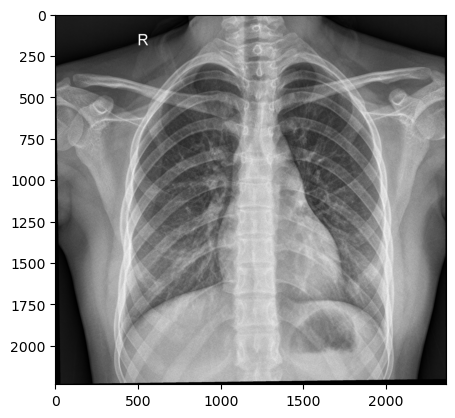

(2359, 2234)


In [4]:
def get_normal_image(number):
    normal_class_dir = os.path.join(train_dir, 'NORMAL')
    normal_train_file_list = os.listdir(normal_class_dir)
    normal_image_path = os.path.join(normal_class_dir, normal_train_file_list[number])
    
    image = Image.open(normal_image_path)
    image_array = np.array(image)

    # Display the image
    plt.imshow(image_array, cmap='gray')
    plt.show()
    print(image.size)
    
    
get_normal_image(0)

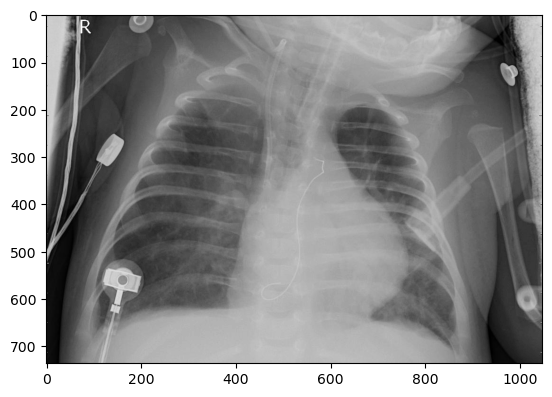

(1048, 736)


In [5]:
def get_pneumonia_image(number):
    pneumonia_class_dir = os.path.join(train_dir, 'PNEUMONIA')
    pneumonia_train_file_list = os.listdir(pneumonia_class_dir)
    pneumonia_image_path = os.path.join(pneumonia_class_dir, pneumonia_train_file_list[number])
    
    image = Image.open(pneumonia_image_path)
    image_array = np.array(image)

    # Display the image
    plt.imshow(image_array, cmap='gray')
    plt.show()
    print(image.size)
    
    
get_pneumonia_image(0)

To the untrained eye, it is difficult to see which lungs are infected and which are not. We will see if we can build a model to pick up on the telltale symptom of pneumonia: clouding of the lungs.

Let's get a better look at the class distribution of the train, validation, and test datasets:

In [6]:
def get_class_counts(directory):
    normal_class_dir = os.path.join(directory, 'NORMAL')
    normal_list = os.listdir(normal_class_dir)

    pneumonia_class_dir = os.path.join(directory, 'PNEUMONIA')
    pneumonia_list = os.listdir(pneumonia_class_dir)
    
    print(len(normal_list))
    print(len(pneumonia_list))

    print('Normal %: ', len(normal_list)/(len(normal_list) + len(pneumonia_list)))
    print('Pneumonia %: ', len(pneumonia_list)/(len(normal_list) + len(pneumonia_list)))

print('Training Class Counts:')
get_class_counts(train_dir)
print('')
print('Validation Class Counts:')
get_class_counts(val_dir)
print('')
print('Test Class Counts:')
get_class_counts(test_dir)

Training Class Counts:
1341
3875
Normal %:  0.2570935582822086
Pneumonia %:  0.7429064417177914

Validation Class Counts:
8
8
Normal %:  0.5
Pneumonia %:  0.5

Test Class Counts:
234
390
Normal %:  0.375
Pneumonia %:  0.625


As mentioned above, we see a fairly large class disparity in our training set, and, while our validation data is evenly distributed, there are only 16 images total. Let's create some data generators so we can experiment using different class distributions.

In this code, we are scaling the images down to values between 0 and 1 as opposed to their normal values between 0 and 256 as RGB images. Next, we are setting the directory the images are to be taken from and dictating the size we want the images to be when they are fed into the model. 512 seems to be the sweet spot between maintaining image quality and not bogging down training time with massive processing volume.

The block below creates a larger validation set by slicing some off images off a shuffled training set. Since only 16 images were in the original validation directory, we are not losing much data by doing it this way. These will serve as our base generators. Notice that our test generator still stands on its own, as it contains an adequate sample size.

In [7]:
# Create an ImageDataGenerator with a validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15)

# Create generators for training and validation
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(512, 512),  # The target size for our images
    batch_size=64,  # The batch size
    class_mode='binary',
    subset='training',  # Set the subset of data to training
    shuffle=True)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(512, 512),
    batch_size=64,
    class_mode='binary',
    subset='validation',  # Set the subset of data to validation
    shuffle=True)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(512,512),
    batch_size=64, class_mode='binary', shuffle=False)

Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Let's take a look at a sample image that comes out of this generator. You might notice that, at 512x512, the quality may be slightly worse than our crisp images with pixel counts in the thousands. Nevertheless, though, it still looks good enough that small aberrations would be visible to the model. In other words, it will still be able to pick up on small nuances and indicators in each image despite the slight decrease in quality.

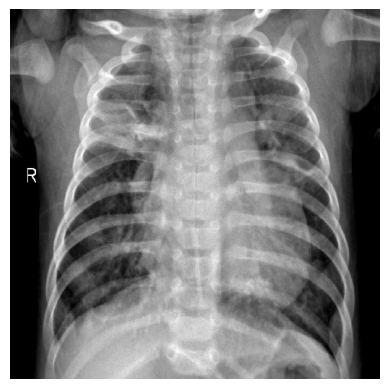

In [8]:
images, labels = next(train_generator)

# Extract a single image from the batch
image = images[0]

# Plot the image
plt.imshow(image)
plt.axis('off')  # Hide the axes for better visualization
plt.show()

Now that we've visualized our data and created our generators, we can move onto building some neural networks!

## Preliminary Modeling

This is where our iterative modeling process begins. Each model will be increasingly complex, with complexity in this case being defined by how many trainable parameters we are dealing with. Additionally, we will be adding optimization techniques such as dropout layers to prevent overfitting. Our later models will be convolutional neural networks, which feature convoluting and pooling layers that reduce the dimensionality of the image data before feeding into normal dense neuron layers. Finally, we will implement transfer learning using MobileNet V2, a CNN with 53 layers that has been trained on over a million images of all kinds. It is often the case that using these models to fit our dataset will yield sueprior results to our base training alone.

Our target metric will be **accuracy**. However, given the nature of the field we are researching, we will also have to be mindful of false positives and false negatives, as high rates of either could have cascading real-world consequences. We will be able to visualize model performance in several ways. These include graphing model loss and performance gains over training epochs. As the models get more complex, it may also be beneficial to visualize the model architectures and activation functions we are using. 

We will begin below with a baseline, vanilla model with only a couple hidden layers:

In [9]:
baseline_model = Sequential()

baseline_model.add(Flatten(input_shape=(512, 512, 3)))
baseline_model.add(Dense(256, activation='relu'))
baseline_model.add(Dense(128, activation='relu'))
baseline_model.add(Dense(1, activation='sigmoid'))

baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 786432)            0         
                                                                 
 dense (Dense)               (None, 256)               201326848 
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 201359873 (768.13 MB)
Trainable params: 201359873 (768.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
class_weights_baseline = {0 : 2, 1 : 1}

history_baseline = baseline_model.fit(
    train_generator, 
    epochs=20, 
    batch_size=64, 
    validation_data=validation_generator,
    class_weight=class_weights_baseline,
    verbose=1)

Epoch 1/20
 8/70 [==>...........................] - ETA: 20s - loss: 1135.1917 - accuracy: 0.5078

KeyboardInterrupt: 

In [11]:
true_labels_baseline = test_generator.classes
predicted_probabilities_baseline = baseline_model.predict(test_generator)
predicted_labels_baseline = predicted_probabilities_baseline > 0.5

10/10 [==============================] - 3s 278ms/step


In [13]:
baseline_report = classification_report(true_labels_baseline, predicted_labels_baseline, target_names=['Normal', 'Pneumonia'])
print(baseline_report)

              precision    recall  f1-score   support

      Normal       0.93      0.42      0.58       234
   Pneumonia       0.74      0.98      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.70      0.71       624
weighted avg       0.81      0.77      0.75       624



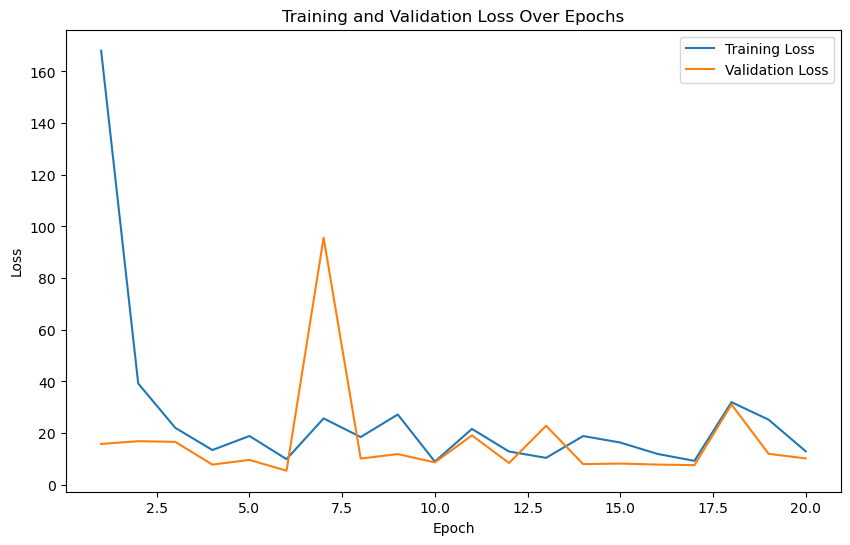

In [14]:
baseline_train_loss = history_baseline.history['loss']
baseline_val_loss = history_baseline.history['val_loss']

epoch_count = range(1, len(baseline_train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epoch_count, baseline_train_loss)
plt.plot(epoch_count, baseline_val_loss)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.show()

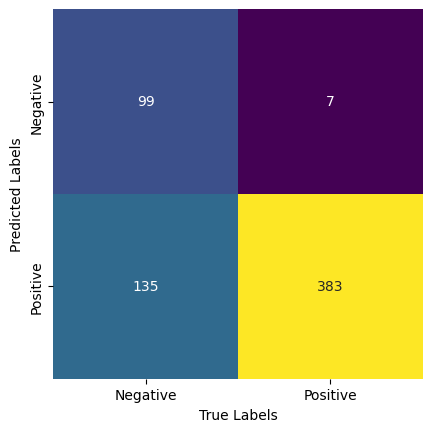

In [17]:
baseline_mat = confusion_matrix(true_labels_baseline, predicted_labels_baseline)
sns.heatmap(baseline_mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='viridis',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

In [18]:
dropout_model = Sequential()

dropout_model.add(Flatten(input_shape=(512, 512, 3)))
dropout_model.add(Dense(256, activation='leaky_relu'))
dropout_model.add(Dropout(0.5))
dropout_model.add(Dense(128, activation='leaky_relu'))
dropout_model.add(Dropout(0.5))
dropout_model.add(Dense(64, activation='leaky_relu'))
dropout_model.add(Dropout(0.5))
dropout_model.add(Dense(1, activation='sigmoid'))

dropout_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

dropout_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 786432)            0         
                                                                 
 dense_7 (Dense)             (None, 256)               201326848 
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)               

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

class_weights_dropout = {0 : 1.9, 1 : 1}

history_dropout = dropout_model.fit(
    train_generator,
    epochs=45
    batch_size=64,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    class_weight=class_weights_dropout,
    verbose=1)

Epoch 1/60
70/70 [==============================] - 29s 416ms/step - loss: 103.1238 - accuracy: 0.6741 - val_loss: 9.5344 - val_accuracy: 0.8325
Epoch 2/60
70/70 [==============================] - 30s 424ms/step - loss: 32.3452 - accuracy: 0.8133 - val_loss: 9.5791 - val_accuracy: 0.8593
Epoch 3/60
70/70 [==============================] - 30s 424ms/step - loss: 25.1345 - accuracy: 0.8293 - val_loss: 11.9095 - val_accuracy: 0.8427
Epoch 4/60
70/70 [==============================] - 30s 432ms/step - loss: 17.7305 - accuracy: 0.8651 - val_loss: 5.1978 - val_accuracy: 0.8734
Epoch 5/60
70/70 [==============================] - 30s 429ms/step - loss: 11.1705 - accuracy: 0.8791 - val_loss: 2.2444 - val_accuracy: 0.9130
Epoch 6/60
70/70 [==============================] - 30s 428ms/step - loss: 7.5251 - accuracy: 0.8920 - val_loss: 2.0041 - val_accuracy: 0.9258
Epoch 7/60
70/70 [==============================] - 30s 427ms/step - loss: 4.9905 - accuracy: 0.9107 - val_loss: 2.0091 - val_accuracy:

KeyboardInterrupt: 

In [21]:
true_labels_dropout = test_generator.classes
predicted_probabilities_dropout = dropout_model.predict(test_generator)
predicted_labels_dropout = predicted_probabilities_dropout > 0.5

10/10 [==============================] - 3s 285ms/step


In [22]:
dropout_report = classification_report(true_labels_dropout, predicted_labels_dropout, target_names=['Normal', 'Pneumonia'])
print(dropout_report)

              precision    recall  f1-score   support

      Normal       0.81      0.76      0.79       234
   Pneumonia       0.86      0.89      0.88       390

    accuracy                           0.84       624
   macro avg       0.83      0.83      0.83       624
weighted avg       0.84      0.84      0.84       624



In [23]:
dropout_train_loss = history_dropout.history['loss']
dropout_val_loss = history_dropout.history['val_loss']

epoch_count = range(1, len(dropout_train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epoch_count, dropout_train_loss)
plt.plot(epoch_count, dropout_val_loss)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.show()

NameError: name 'history_dropout' is not defined

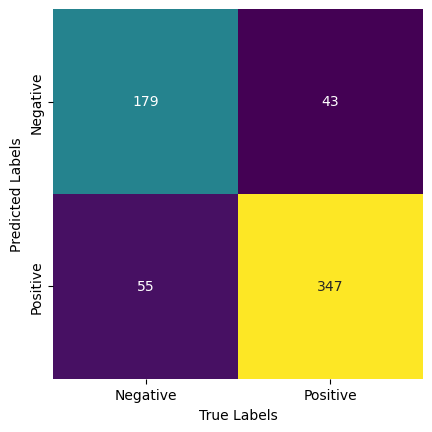

In [25]:
dropout_mat = confusion_matrix(true_labels_dropout, predicted_labels_dropout)
sns.heatmap(dropout_mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='viridis',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

In [1]:
layer_name = 'dense' 
intermediate_layer_model = Model(inputs=baseline_model.input,
                                 outputs=baseline_model.get_layer(layer_name).output)

# Select some data to pass through the model
data_samples, labels = next(train_generator)

# Get the output of the layer
activations = intermediate_layer_model.predict(data_samples)

# Now plot the activations of the first neuron as an example
plt.figure(figsize=(10, 4))
plt.plot(activations[16], label=f'Activations of first neuron in {layer_name}')
plt.title('Activations')
plt.xlabel('Activation Index')
plt.ylabel('Activation Value')
plt.legend()
plt.show()

NameError: name 'Model' is not defined

In [11]:
# Define the CNN model
cnn_model = Sequential()

# Convolutional layer block 1 with Batch Normalization
cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='leaky_relu', input_shape=(512, 512, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer block 2
cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='leaky_relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer block 3
cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='leaky_relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten before passing to the dense layers
cnn_model.add(Flatten())

# Dense layers
cnn_model.add(Dense(256, activation='leaky_relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(128, activation='leaky_relu'))
cnn_model.add(Dropout(0.5))

# Output layer
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 255, 255, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 126, 126, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 62, 62, 128)      

In [12]:
early_stopping_cnn = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

class_weights_cnn = {0 : 1.9, 1 : 1}

history_cnn = cnn_model.fit(
    train_generator,
    epochs=60,
    batch_size=64,
    validation_data=validation_generator,
    callbacks=[early_stopping_cnn],
    class_weight=class_weights_cnn,
    verbose=1)

Epoch 1/60
70/70 [==============================] - 58s 810ms/step - loss: 1.1139 - accuracy: 0.7760 - val_loss: 0.2590 - val_accuracy: 0.8785
Epoch 2/60
70/70 [==============================] - 54s 764ms/step - loss: 0.2339 - accuracy: 0.9285 - val_loss: 0.1581 - val_accuracy: 0.9386
Epoch 3/60
70/70 [==============================] - 55s 780ms/step - loss: 0.1424 - accuracy: 0.9601 - val_loss: 0.1086 - val_accuracy: 0.9552
Epoch 4/60
70/70 [==============================] - 54s 765ms/step - loss: 0.1200 - accuracy: 0.9682 - val_loss: 0.0976 - val_accuracy: 0.9591
Epoch 5/60
70/70 [==============================] - 52s 744ms/step - loss: 0.0912 - accuracy: 0.9752 - val_loss: 0.1229 - val_accuracy: 0.9540
Epoch 6/60
70/70 [==============================] - 54s 762ms/step - loss: 0.1004 - accuracy: 0.9723 - val_loss: 0.1604 - val_accuracy: 0.9514
Epoch 7/60
70/70 [==============================] - 54s 766ms/step - loss: 0.0555 - accuracy: 0.9838 - val_loss: 0.1035 - val_accuracy: 0.9668

In [17]:
true_labels_cnn = test_generator.classes
predicted_probabilities_cnn = cnn_model.predict(test_generator)
predicted_labels_cnn = predicted_probabilities_cnn > 0.5

10/10 [==============================] - 3s 298ms/step


In [18]:
cnn_report = classification_report(true_labels_cnn, predicted_labels_cnn, target_names=['Normal', 'Pneumonia'])
print(cnn_report)

              precision    recall  f1-score   support

      Normal       0.99      0.31      0.47       234
   Pneumonia       0.71      1.00      0.83       390

    accuracy                           0.74       624
   macro avg       0.85      0.65      0.65       624
weighted avg       0.81      0.74      0.70       624



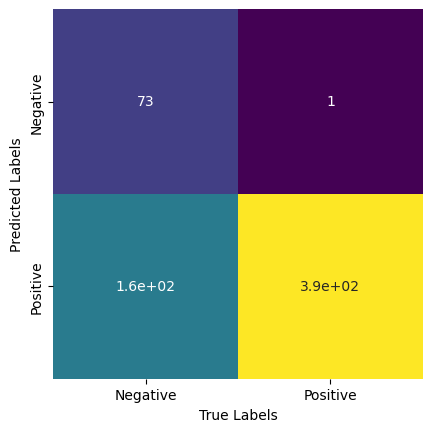

In [21]:
cnn_mat = confusion_matrix(true_labels_cnn, predicted_labels_cnn)
sns.heatmap(cnn_mat.T, square=True, annot=True, cbar=False, cmap='viridis',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

In [22]:
layer_outputs = [layer.output for layer in cnn_model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=cnn_model.input, outputs=layer_outputs)

In [23]:
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 31], cmap='gray')
plt.show()

NameError: name 'img_tensor' is not defined

In [ ]:
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 30], cmap='gray')
plt.show()

In [ ]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='gray')

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(12,8))

layer_names = []
for layer in cnn_model.layers[:8]:
    layer_names.append(layer.name)

for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 29], cmap='gray')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

In [24]:
mobilenet_train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # The target size for your images
    batch_size=64,  # The batch size
    class_mode='binary',
    subset='training',  # Set the subset of data to training
    shuffle=True)

mobilenet_validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    subset='validation',  # Set the subset of data to validation
    shuffle=True)

mobilenet_test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=64, class_mode='binary', shuffle=False)

Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [26]:
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet.trainable = False  # Freeze the convolutional base

# Create a new model on top
transfer_model = Sequential()

transfer_model.add(mobilenet)
transfer_model.add(GlobalAveragePooling2D())
transfer_model.add(Dense(512, activation='relu'))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(1, activation='sigmoid'))

# Compile the model
transfer_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

transfer_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2914369 (11.12 MB)
Trainable params: 656

In [ ]:
transfer_early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min', restore_best_weights=True)

transfer_model_checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='min')

transfer_class_weights = {0 : 2, 1 : 1}

transfer_history = transfer_model.fit(
    mobilenet_train_generator,
    steps_per_epoch=mobilenet_train_generator.n // mobilenet_train_generator.batch_size,
    epochs=10,
    validation_data=mobilenet_validation_generator,
    validation_steps=mobilenet_validation_generator.n // mobilenet_validation_generator.batch_size,
    callbacks=[transfer_early_stopping, transfer_model_checkpoint],
    class_weight=transfer_class_weights,
    verbose=1)

In [ ]:
predicted_probabilities_transfer = transfer_model.predict(mobilenet_test_generator)
predicted_labels_transfer = predicted_probabilities_transfer > 0.5

In [ ]:
mobilenet_true_labels = mobilenet_test_generator.classes
transfer_report = classification_report(mobilenet_true_labels, predicted_labels_transfer, target_names=['Normal', 'Pneumonia'])
print(transfer_report)

In [ ]:
transfer_train_loss = transfer_history.history['loss']
transfer_val_loss = transfer_history.history['val_loss']

epoch_count = range(1, len(transfer_train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epoch_count, transfer_train_loss)
plt.plot(epoch_count, transfer_val_loss)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [ ]:
transfer_mat = confusion_matrix(true_labels_vanilla, predicted_labels_transfer)
sns.heatmap(transfer_mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='viridis',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

## Final Model

# Conclusions

## Next Steps

## Contact Information